# Lorenz curves

In [2]:
%load_ext autoreload
%autoreload 2

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from itrx import Itr

from spatial import map_to_spatial_unit, get_force_boundary
from utils import CATEGORIES, Month, calc_gini, load_crime_data, lorenz_curve, monthgen, random_crime_data_by_feature

In [60]:
# get the crime data
FORCE = "West Yorkshire"
LATEST_DATE = Month(2025, 5)
SPATIAL_UNIT = "LSOA"
raw_crime_data = load_crime_data(FORCE, Itr(monthgen(LATEST_DATE, backwards=True)).take(36).rev())
force_boundary = get_force_boundary(FORCE)

In [ ]:
crime_data, features = map_to_spatial_unit(raw_crime_data, force_boundary, SPATIAL_UNIT)
crime_data

In [120]:
# compute spatio-temporo-categorical counts
all_categories = crime_data["Crime type"].unique()
counts = crime_data.groupby(["Month", "spatial_unit", "Crime type"])["Reported by"].count()
counts

Month    spatial_unit  Crime type                  
2022-06  E01010568     Public order                     2
                       Vehicle crime                    1
                       Violence and sexual offences     2
         E01010569     Anti-social behaviour            2
                       Bicycle theft                    1
                                                       ..
2025-05  E01035054     Robbery                          2
                       Shoplifting                      6
                       Theft from the person            1
                       Vehicle crime                    6
                       Violence and sexual offences    11
Name: Reported by, Length: 288283, dtype: int64

## See how stable rates are for 3 categories

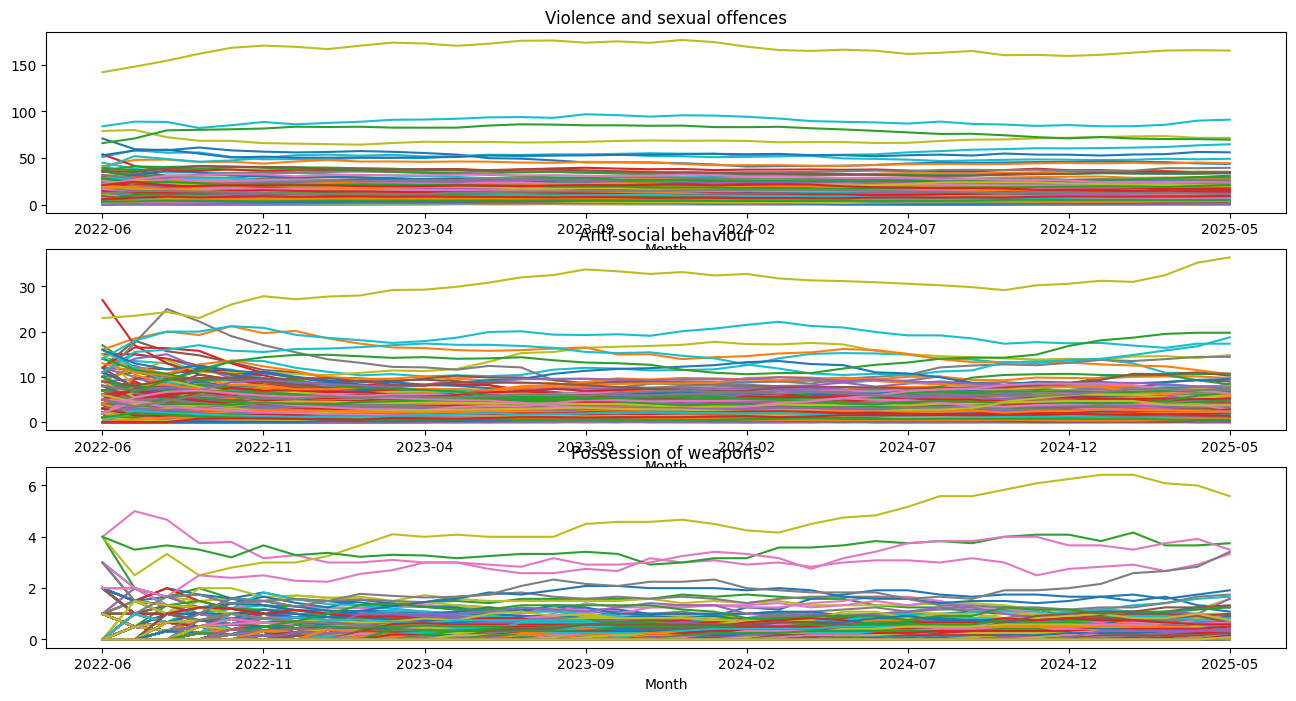

In [121]:
fig, axs = plt.subplots(3, figsize=(18, 9))
for i, category in enumerate(CATEGORIES):
    cat_counts = (
        counts.loc[(slice(None), slice(None), category)]
        .unstack(level="spatial_unit", fill_value=0)
        .rolling(12, min_periods=1)
        .mean()
    )
    cat_counts.plot(legend=False, figsize=(16, 8), title=category, ax=axs[i])

## Compute Lorenz curves for the 3 year mean in each location for each category

Text(0, 0.5, 'Proportion of crime')

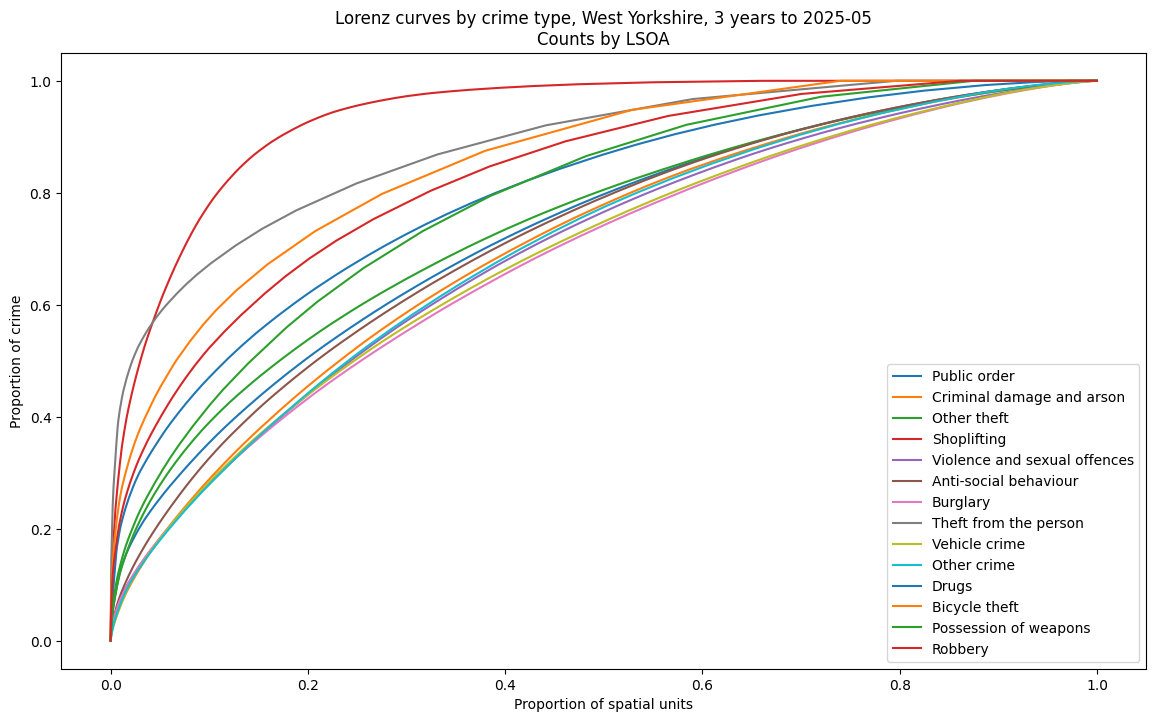

In [122]:
fig, ax = plt.subplots(figsize=(14, 8))
for category in all_categories:
    # annualise (somewhat pointless as is gets normalised)
    cat_means = counts.loc[(slice(None), slice(None), category)].unstack(level="spatial_unit", fill_value=0).mean()
    # cat_counts.plot(legend=False, figsize=(16, 8), title=category, ax=axs[i])
    lc = lorenz_curve(cat_means.reindex(features.index).fillna(0))
    lc.plot(label=category, ax=ax)
ax.legend()
ax.set_title(f"Lorenz curves by crime type, {FORCE}, 3 years to {LATEST_DATE}\nCounts by {SPATIAL_UNIT}")
ax.set_xlabel("Proportion of spatial units")
ax.set_ylabel("Proportion of crime")

### Calculate Gini coefficient 

Focussing on antisocial behaviour

In [123]:
asb_data = counts.loc[(slice(None), slice(None), CATEGORIES[1])].unstack(level="Month", fill_value=0)
assert len(asb_data) == len(features)  # ensure we haven't dropped any crime-free units

random_data = (
    random_crime_data_by_feature(asb_data.sum().sum(), features, asb_data.columns)
    .groupby(["spatial_unit", "Month"])["Crime type"]
    .count()
    .rename("count")
    .unstack(level="Month", fill_value=0)
)
gini = pd.DataFrame(
    index=asb_data.columns,
    data={
        "Actual": [calc_gini(s)[0] for _, s in asb_data.items()],
        "Random": [calc_gini(s)[0] for _, s in random_data.items()],
    },
)

gini
# random_data

,Actual,Random
Month,,
2022-06,0.607761,0.404867
2022-07,0.592658,0.431661
2022-08,0.590868,0.411020
2022-09,0.640078,0.426322
2022-10,0.640214,0.417322
2022-11,0.675531,0.427230
2022-12,0.743676,0.421412
2023-01,0.690892,0.421706
2023-02,0.670955,0.435324


In [ ]:
# repeat the calculation for similarly-sized regular spatial units
crime_data_r, features_r = map_to_spatial_unit(
    raw_crime_data[raw_crime_data["Crime type"] == CATEGORIES[1]], force_boundary, "GRID", size=1200
)
asb_data = (
    crime_data_r.groupby(["Month", "spatial_unit"])["Reported by"]
    .count()
    .unstack(level="Month", fill_value=0)
    .reindex(features_r.index, fill_value=0)
)
assert len(asb_data) == len(features_r)
asb_data

Month,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05
63,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2394,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2395,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2437,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [125]:
random_data = (
    random_crime_data_by_feature(asb_data.sum().sum(), features, asb_data.columns)
    .groupby(["spatial_unit", "Month"])["Crime type"]
    .count()
    .rename("count")
    .unstack(level="Month", fill_value=0)
)
gini_r = pd.DataFrame(
    index=asb_data.columns,
    data={
        "Actual": [calc_gini(s)[0] for _, s in asb_data.items()],
        "Random": [calc_gini(s)[0] for _, s in random_data.items()],
    },
)

<Axes: title={'center': '1200m grid'}, xlabel='Month'>

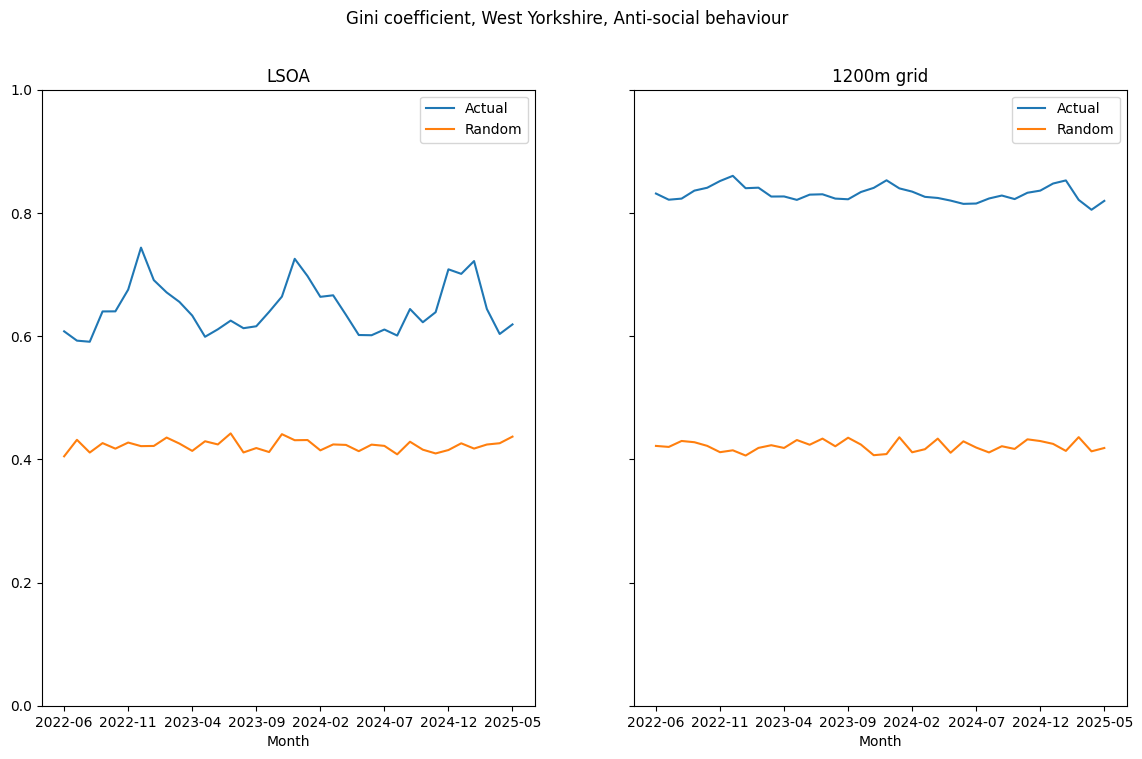

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
fig.suptitle(f"Gini coefficient, {FORCE}, {CATEGORIES[1]}")
gini.plot(title=f"{SPATIAL_UNIT}", ylim=(0, 1), ax=axs[0])
gini_r.plot(title=f"1200m grid", ax=axs[1])